<font size=6>B13 setup - PLE scan</font>

In [1]:
import sys
sys.path.append("..")
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from LowLevelModules.GeneralFunctions import *
from scipy.optimize import curve_fit
from LowLevelModules.NIdaqAPD import *
from collections import deque
from LowLevelModules.bristol_wavelength_meter_client import *
from LowLevelModules.EFW_filter import *
import visa
from pyvisa import util
from LowLevelModules.Instruments import DG645

import nidaqmx
import numpy as np
import time

from LowLevelModules.NIdaq import *
from pymeasure.instruments.thorlabs import ThorlabsPM100USB

In [2]:
DG645_address = 'GPIB0::15::INSTR'

bristolCOM = 7

scan_terminal = '/Dev2/ao1' # laser scan

DG_trig_terminal = '/Dev2/port1/line3'

shutter_ctrl_terminal ='/Dev1/port0/line1'

APD_terminal = '/Dev1/PFI3'
APD_ctr = '/Dev1/ctr2' # APD counter

In [3]:
def toptica_bounded_write(v):
    """clamp the output voltage v [Volt] to be -5 <= v <= +5"""
    with nidaqmx.Task() as task_toptica:
        task_toptica.ao_channels.add_ao_voltage_chan(scan_terminal, 'Piezo scan', min_val=-5, max_val=5)
        vup = 5
        vdown = -5
        v_bound = max(  min(vup,v),vdown    )    
        task_toptica.write(v, auto_start=True, timeout=5) # write a single data    

def shutter_ctrl_write(v):
    """write a digital signal to shutter
    maximum frequency of operation - 10 Hz (continuous)
    40 Hz - burst - 4 sec maximum with 1 minute minimum between burst
    """
    with nidaqmx.Task() as do_task:
        do_task.do_channels.add_do_chan(shutter_ctrl_terminal)
        do_task.write(v)      

def DG_trig_write_pulse():
    """generate a digital pulse of width around 1-3 ms depends on latency"""
    with nidaqmx.Task() as do_task:
        do_task.do_channels.add_do_chan(DG_trig_terminal)
        do_task.write(True)
        do_task.write(False)
        
def DG_trig_write(b):
    """write a single bit (True/False) """
    with nidaqmx.Task() as do_task:
        do_task.do_channels.add_do_chan(DG_trig_terminal)
        do_task.write(b)
        
def setupBristol(COM):
    """
    input - COM number
    set wavelength unit to nm-air, power unit to mW
    return wavemeter handle
    """
    bristol521handle=CLOpenUSBSerialDevice(COM)
    CLSetLambdaUnits(bristol521handle,'nm')
    CLSetPowerUnits(bristol521handle,'mw')
    CLSetMedium(bristol521handle,'air')
    return bristol521handle

def readBristol(handle):
    """
    return wavelength, power 
    """
    currentLambda = CLGetLambdaReading(handle)
    currentPower = CLGetPowerReading(handle)
    return currentLambda,currentPower

In [4]:
# while True:
#     try:
#         DG_trig_write_pulse()
#         time.sleep(0.1)
#     except:
#         break

In [5]:
# https://stackoverflow.com/questions/19547084/can-i-explicitly-close-a-ctypes-cdll
# windll.kernel32.FreeLibrary(bristol521handle)
# does not seem to actually close the handle

In [4]:
shutter_ctrl_write(True)

In [5]:
efw_instance = EFW() # run once only

In [6]:
# switch filter to 750 LP
efw_instance.change_filter('750LP')
while True:
    if efw_instance.read_position() == efw_instance.EFW_wheel_filter['750LP']:
        break
    else:
        efw_instance.change_filter('750LP')

In [7]:
efw_instance.read_position()

4

In [8]:
efw_instance.EFW_wheel_filter['750LP']

4

In [9]:
bristol521handle=setupBristol(bristolCOM)
readBristol(bristol521handle)

(0.0, 0.0)

In [10]:
readBristol(bristol521handle)

(0.0, 0.0)

In [11]:
def line(x,  a, b):
    return a*x+b

def pulse_wfm(t,tstart,width):
    return np.heaviside(t-tstart,0)-np.heaviside(t-tstart-width,0)

In [12]:
def FP_scan(ao_pts_half = 250,v_final = 6.0):
    """
    Fabry Perot triangular scan - 0 V to v_final to 0 V
    scan and acquisition only
    return time series, FP piezo voltage, PD voltage (array)
    """
    a = np.linspace(0,v_final,ao_pts_half) 
    b = np.linspace(v_final,0,ao_pts_half) 
    v_ao_scan = np.concatenate((a,b),axis=None)
    ao_pts = ao_pts_half*2

    ao_scan_rate = 5000
    ao_trig_src =  '/Dev2/PFI0'
    ai_trig_src =  '/Dev2/PFI1'

    # time
    t0 = np.linspace(0,(ao_pts-1)/ao_scan_rate,ao_pts)

    dig_trig = DO('/Dev2/port0/line0')    
    dig_trig.write(False)

    # set up  AO AI
    FPtask = AO('/Dev2/ao0')
    cavityPDtask = AI('/Dev2/ai0')

    FPtask.config_write(v_ao_scan,ao_scan_rate,ao_trig_src)
    cavityPDtask.config_read_rising(ao_pts,ao_scan_rate,ai_trig_src)

    # start FP scan
    dig_trig.write(True)
    FPtask.wait_until_done()
    aiV = cavityPDtask.read(number_of_samples_per_channel=ao_pts)

    FPtask.close()
    cavityPDtask.close()   
    dig_trig.write(False)
    dig_trig.close()
    return t0,v_ao_scan,aiV

def FP_fit(tarray,piezo, PD, userange=250):
    """
    fit a lorentzian + sine to the input
    assume piezo is either linearly increasing or decreasing
    only use the wave in [0:userange-1]    
    return (amp, cen, fwhm, bkg, asin,fsin,phisin)
    """
    npts = min(len(piezo),userange)
    vrange = np.amax(piezo[0:userange-1])-np.amin(piezo[0:userange-1])
    scan_rate = 1/(tarray[1]-tarray[0])
    init_vals = [np.amin(PD), piezo[np.argmin(PD)], 0.2, 0.05,0.1,60*npts/scan_rate/vrange,1]
    try:
        best_vals, covar = curve_fit(lorentziansin, piezo[0:userange-1], PD[0:userange-1], p0=init_vals)
        return best_vals
    except:
        print('Fit error')
        return init_vals*0

def unwrap_custom(arrayin,period):
    """unwrap with custom period"""
    arrayout =period/2/np.pi*np.unwrap(np.array(arrayin)*2*np.pi/period)
    return arrayout

def unwrap_by_pt(curr_pt,prev_pt,period):
    """unwrap with custom period"""
    if curr_pt-prev_pt >period/2:
        return curr_pt - period
    elif curr_pt-prev_pt <-period/2:
        return curr_pt + period
    else:
        return curr_pt

In [11]:
unwrap_by_pt(0.7,0,1)

-0.30000000000000004

<font size=6>set DAQ counter clock output</font>

In [13]:
# setup DG645 - 637, 737, RF switch
# in us
# Note - there is about 85 ns delay from external trigger to T0 rising edge

# setup such that we use both 532 and 637 laser as excitation

time_per_point = 1 # sec 
init_time = 1e-6 # 532 nm and 637 nm, sec
PLE_time = 1e-6 # 737 nm, sec
delay637 = 0.048e-6 # sec
delay737 = 0.860e-6 # sec
delay532 = 0.620e-6 # sec

# maximum of the delay time
delay_init = max(delay637,delay532)
delay_resonance = delay737

marginFront = 0.100e-6 # allow the excitation laser to truely turn off, let the defect decays to its ground state
marginBack = 0.050e-6 # some margin at the back to avoid the initialization laser turning on in the PLE time

# AB - 532, CD - 737, EF - 637 digital modulation, GH - RF switch
# See DG645 manual p56 delay and output commmands
BNC_532 = 1 # AB
ch1_532 = 2 # A
ch2_532 = 3 # B

BNC_737 = 2 # CD
ch1_737 = 4 # C
ch2_737 = 5 # D

BNC_637 = 3 # EF
ch1_637 = 6 # E
ch2_637 = 7 # F

BNC_switch = 4 # GH
ch1_switch = 8 # G
ch2_switch = 9 # H

BNC_init = BNC_637
ch1_init = ch1_637
ch2_init = ch2_637

BNC_resonance = BNC_737
ch1_resonance = ch1_737
ch2_resonance = ch2_737

# nominal dark time for the init laser
darkTime = marginFront + PLE_time + marginBack # excitation laser off

TTL_delay_resonance = max(0, delay_init + marginFront - delay_resonance )
TTL_delay_init = max(0, delay_resonance - delay_init - marginFront)

# TTL_delay_532 = max(0, delay_resonance - delay532 - marginFront)
# TTL_delay_637 = max(0, delay_resonance - delay637 - marginFront)

TTL_delay_532 = TTL_delay_init
TTL_delay_637 = TTL_delay_init + delay_init - delay637

initMargin = 0.100e-6

cycleEndInitTime = max(initMargin, init_time - TTL_delay_init - delay_init)
cycle_time = TTL_delay_init + delay_init + darkTime + cycleEndInitTime

num_cycle = int(np.ceil(time_per_point/cycle_time)) # must be integer

In [13]:
delay532

6.2e-07

In [14]:
num_cycle

465117

In [14]:
cycle_time

2.1499999999999997e-06

In [15]:
TTL_delay_637

7.12e-07

In [16]:
TTL_delay_resonance

0

In [14]:
def DG645_init():
    """
    set DG645 to burst mode
    
    """
    dg_source = DG645(DG645_address)

    # set output polarity
    dg_source.set_polarity(BNC_532,0) # negative polarity, default HIGH
    dg_source.set_polarity(BNC_637,0)
    dg_source.set_polarity(BNC_737,1) # positive polarity, default LOW
    dg_source.set_polarity(BNC_switch,1)

    # repump/initialization
    dg_source.set_delay(ch1_532,0,TTL_delay_532)
    dg_source.set_delay(ch2_532,ch1_532,darkTime)

    dg_source.set_delay(ch1_637,0,TTL_delay_637)
    dg_source.set_delay(ch2_637,ch1_637,darkTime)

    # resonance excitaiton
    dg_source.set_delay(ch1_resonance,0,TTL_delay_resonance)
    dg_source.set_delay(ch2_resonance,ch1_resonance,PLE_time)

    # collection
    dg_source.set_delay(ch1_switch,0,TTL_delay_resonance+delay_resonance)
    dg_source.set_delay(ch2_switch,ch1_switch,PLE_time)

    dg_source.set_burst_mode(1)
    dg_source.set_burst_period(cycle_time)
    dg_source.set_burst_delay(0)
    dg_source.set_burst_count(num_cycle)
    dg_source.close()
    
def DG645_default():

    dg_source = DG645(DG645_address)

    # set output polarity
    dg_source.set_polarity(BNC_532,0) # negative polarity, default HIGH
    dg_source.set_polarity(BNC_637,0)
    dg_source.set_polarity(BNC_737,0) 
    dg_source.set_polarity(BNC_switch,1) # positive polarity, default LOW
    
    dg_source.close()
        
def DG645_737_polarity(p):
    """
    turn on or off 737 laser (default state)
    0 -> negative polarity, default ON
    1 -> positive polarity, default OFF
    """
    dg_source = DG645(DG645_address)
    dg_source.set_polarity(BNC_737,p)    
    dg_source.close()
    
def DG645_set_polarity(chan,p):
    """
    turn on or off chan (channel, BNC_532, BNC_637 or BNC_737)
    0 -> negative polarity, default ON
    1 -> positive polarity, default OFF
    """
    dg_source = DG645(DG645_address)
    dg_source.set_polarity(chan,p)    
    dg_source.close()

In [18]:
num_cycle

465117

In [19]:
print(num_cycle)
print(cycle_time)

465117
2.1499999999999997e-06


In [23]:
dg_source = DG645(DG645_address)
print(dg_source.set_burst_count(10.0))
dg_source.close()

None


In [22]:
dg_source = DG645(DG645_address)
print(dg_source.get_burst_count())
dg_source.close()

465117



In [25]:
cycle_time*1e6

2.15

In [26]:
DG645_737_polarity(True)

In [15]:
DG645_init()

In [16]:
DG645_default()

In [17]:
# simulate sequence
# plot 2 cycles
plot_pts = 1000
tplot = np.linspace(0,cycle_time,plot_pts)
plt_TTL_532 = 1-pulse_wfm(tplot,TTL_delay_532,darkTime)
plt_laser_532 = 1-pulse_wfm(tplot,TTL_delay_532+delay532,darkTime)

plt_TTL_637 = 1-pulse_wfm(tplot,TTL_delay_637,darkTime)
plt_laser_637 = 1-pulse_wfm(tplot,TTL_delay_637+delay637,darkTime)

plt_TTL_resonance = pulse_wfm(tplot,TTL_delay_resonance,PLE_time)
plt_laser_resonance = pulse_wfm(tplot,TTL_delay_resonance+delay_resonance,PLE_time)

plt_rf = pulse_wfm(tplot,TTL_delay_resonance+delay_resonance,PLE_time)

# plt.plot(tplot,plt_TTL_532)
# plt.plot(tplot,plt_laser_532)
# plt.plot(tplot,plt_TTL_637)
# plt.plot(tplot,plt_laser_637)
# plt.plot(tplot,plt_TTL_resonance)
# plt.plot(tplot,plt_laser_resonance)

# plt.plot(tplot,plt_rf)

<IPython.core.display.Javascript object>


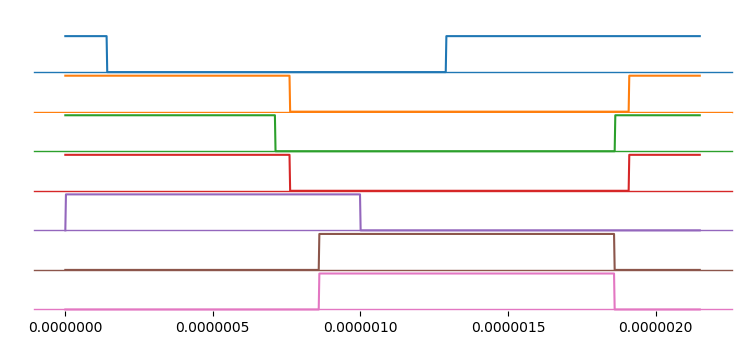

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

segments = 7
points_per_segment = 1000

#your data preparation will vary
x = np.tile(np.linspace(0,cycle_time,plot_pts), segments)
z = np.floor(np.arange(points_per_segment * segments)/points_per_segment)
y = np.sin(x * (1 + z))

a =plt_TTL_532
b =plt_laser_532
c =plt_TTL_637
d =plt_laser_637
e =plt_TTL_resonance
f =plt_laser_resonance
g =plt_rf


y=np.concatenate((a,b,c,d,e,f,g), axis=None)

df = pd.DataFrame({'x': x, 'y': y, 'z': z})

pal = sns.color_palette()
g = sns.FacetGrid(df, row="z", hue="z", aspect=15, height=.5, palette=pal)
g.map(plt.plot, 'x', 'y')
g.map(plt.axhline, y=0, lw=1, clip_on=False)
# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.00)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.show()

In [ ]:
# how long does it take for the toptica laser to stabilize in wavelength and power once I step the piezo voltage control?


<font size=6>Scan laser and measure wavelength and power</font>

In [32]:
toptica_bounded_write(-5)

<IPython.core.display.Javascript object>


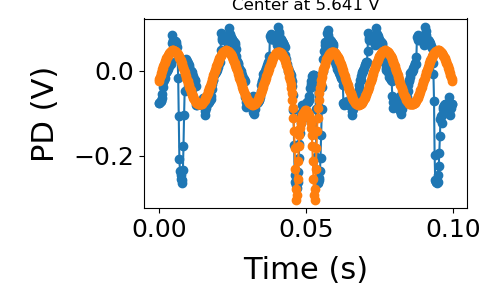

<IPython.core.display.Javascript object>


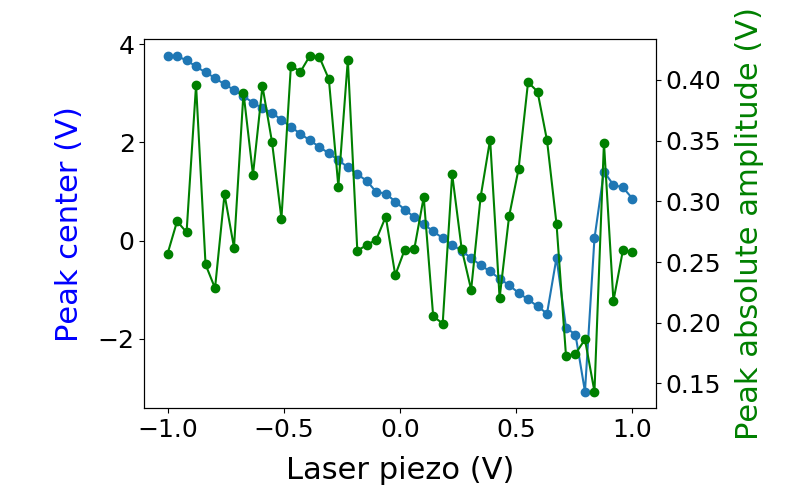

<IPython.core.display.Javascript object>


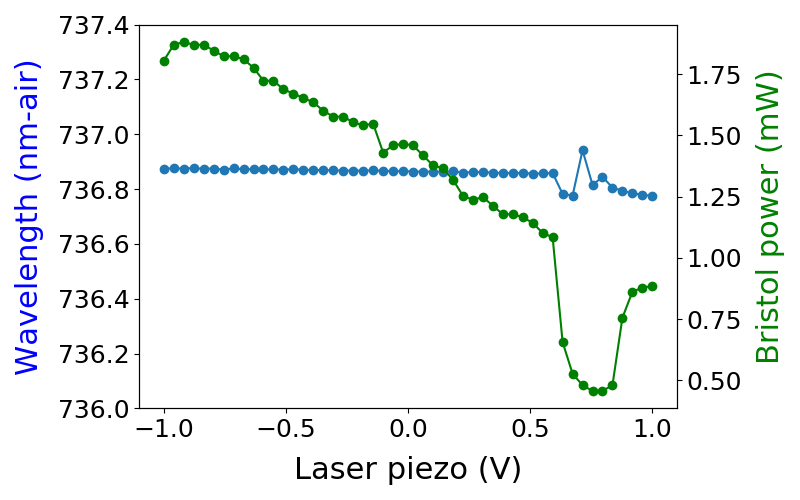

In [56]:
# scan laser frequency in discrete steps
# software timed
voltage = np.linspace(-1,1,50)
FP_FSR_V = 4.783
lpFP = LivePlot(1, 2, 5, 3, 'o', 'Time (s)',"PD (V)")
lpLRFP = LivePlotLR(1, 1, 8, 5, 'o', 'Laser piezo (V)', 'Peak center (V)','Peak absolute amplitude (V)')
lpLR = LivePlotLR(1, 1, 8, 5, 'o', 'Laser piezo (V)', 'Wavelength (nm-air)','Bristol power (mW)')

volt_so_far=[]
powerlist=[]
lambdalist=[]

FPlambda=[]
FPpower=[]
for ind,v in enumerate(voltage):
    toptica_bounded_write(v)
    volt_so_far.append(v)
    # read fabry perot - need to start the read and write channel at the same time
    t0_this,v_ao_scan_this,aiV_this = FP_scan()
    best_vals = FP_fit(t0_this[0:249],v_ao_scan_this[0:249], aiV_this[0:249])
    if ind==0:
        FPlambda.append(best_vals[1])
    else:
        FPlambda.append(unwrap_by_pt(best_vals[1],FPlambda[ind-1],FP_FSR_V))
                        
    FPpower.append(-best_vals[0])
    
    yfit = lorentziansin(v_ao_scan_this, best_vals[0], best_vals[1],best_vals[2],best_vals[3],best_vals[4],best_vals[5],best_vals[6])
    lpFP.plot_live(t0_this,aiV_this,yfit)
    lpFP.ax1.set_title(f'Center at {best_vals[1]:.3f} V')
    plt.tight_layout()
    time.sleep(0.1)
    
    lpLRFP.plot_live(volt_so_far, FPlambda,FPpower)
    
    # read wavemeter
    currentLambda = CLGetLambdaReading(bristol521handle)
    currentPower = CLGetPowerReading(bristol521handle)
    lambdalist.append(currentLambda)
    powerlist.append(currentPower)
    
    lpLR.plot_live(volt_so_far, lambdalist,powerlist)
    lpLR.ax1.set_ylim([736,737.4])

toptica_bounded_write(0)

In [40]:
# FPlambda_unwrap = unwrap_custom(FPlambda,4.783)

Wavelength (nm-air)= a*V+b
(a,b) = [-1.26774928e-02  7.36864457e+02]
Voltage range (V) = 1.429
Mode hop free tuning range (nm-air) = 0.018
Power init (mW) = 1.846, Power init (mW) = 0.656, power ratio = 2.813


<IPython.core.display.Javascript object>


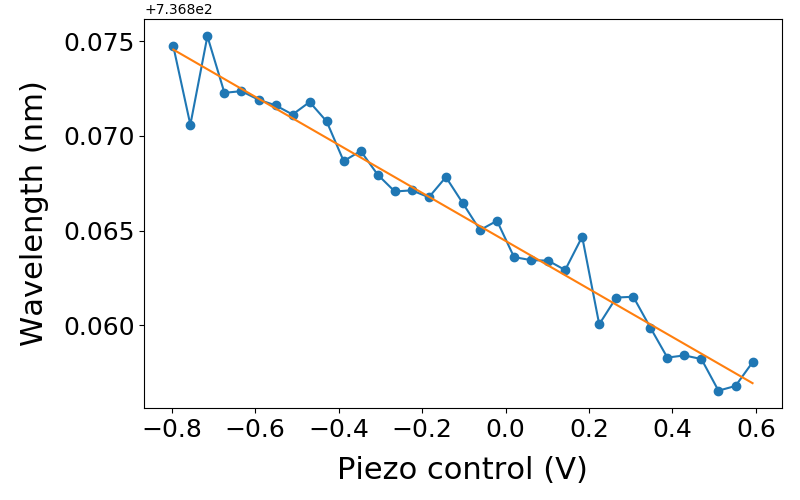

FP peak position (V)= a*Vpiezo+b
(a,b) = [-3.42513142  0.69761948]


<IPython.core.display.Javascript object>


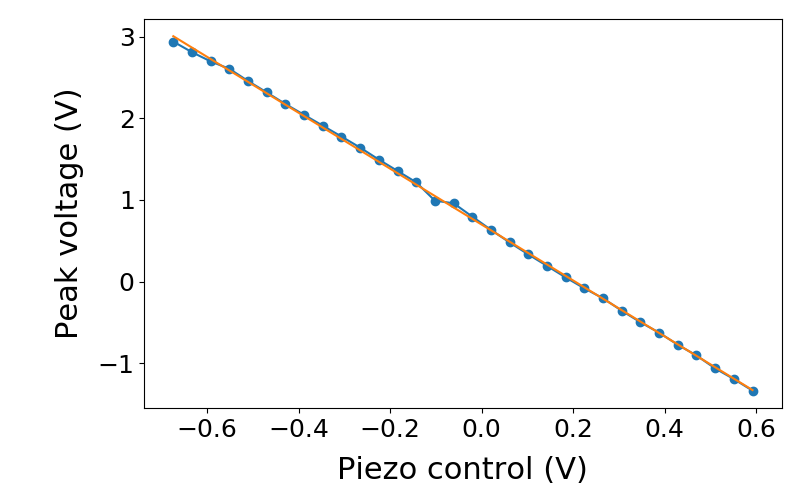

In [67]:
init_vals = [0.01,737]

xinit = 5
xfin = 40
best_vals, covar = curve_fit(line,voltage[xinit:xfin], lambdalist[xinit:xfin], p0=init_vals)
print(f'Wavelength (nm-air)= a*V+b')
print(f'(a,b) = {best_vals}')
# print('best_vals: {}'.format(best_vals))
# print((voltage[xfin]-voltage[xinit])) 
print(f'Voltage range (V) = {voltage[xfin]-voltage[xinit]:.3f}')
print(f'Mode hop free tuning range (nm-air) = {abs(best_vals[0]*(voltage[xfin]-voltage[xinit])):.3f}')
print(f'Power init (mW) = {powerlist[xinit]:.3f}, Power init (mW) = {powerlist[xfin]:.3f}, power ratio = {powerlist[xinit]/powerlist[xfin]:.3f}')
# print(best_vals[0]*(voltage[xfin]-voltage[xinit])) 
# print(powerlist[xfin],powerlist[xinit],powerlist[xinit]/powerlist[xfin])
lpFit = LivePlot(1, 1, 8, 5, 'o', 'Piezo control (V)',"Wavelength (nm)")
lpFit.plot_live(voltage[xinit:xfin],lambdalist[xinit:xfin])
plt.plot(voltage[xinit:xfin], line(voltage[xinit:xfin], best_vals[0], best_vals[1]),
         label='Fitted function')
# lpFit.ax1.set_ylim([737.05,737.15])

xinit=8
xfin=40
best_vals, covar = curve_fit(line,voltage[xinit:xfin], FPlambda[xinit:xfin], p0=init_vals)
# print('best_vals: {}'.format(best_vals))

print(f'FP peak position (V)= a*Vpiezo+b')
print(f'(a,b) = {best_vals}')

lpFit2 = LivePlot(1, 1, 8, 5, 'o', 'Piezo control (V)',"Peak voltage (V)")
lpFit2.plot_live(voltage[xinit:xfin],FPlambda[xinit:xfin])
plt.plot(voltage[xinit:xfin], line(voltage[xinit:xfin], best_vals[0], best_vals[1]),
         label='Fitted function')
# lpFit.ax1.set_ylim([737.05,737.15])




<IPython.core.display.Javascript object>


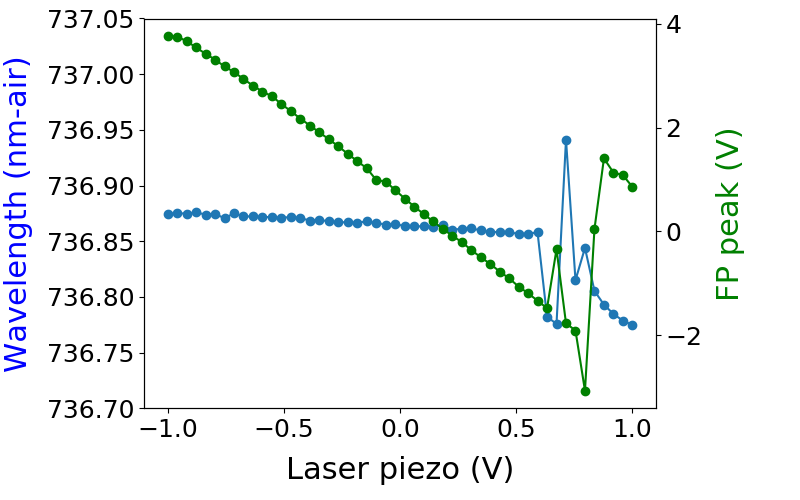

(736.7, 737.05)

In [64]:
lpLR3 = LivePlotLR(1, 1, 8, 5, 'o', 'Laser piezo (V)', 'Wavelength (nm-air)','FP peak (V)')
lpLR3.plot_live(voltage,lambdalist,FPlambda)
lpLR3.ax1.set_ylim([736.7,737.05])

<font size=6>Incremental save</font>

In [13]:
emptyA = np.empty([0])

In [6]:
fname=data_save(emptyA, figure=None, data_type="IncrementalSave", header="try")
f= open(fname,"a")

C:\data\191108\IncrementalSave\IncrementalSave_190517.txt


In [10]:
fname

'C:\\data\\191108\\IncrementalSave\\IncrementalSave_191004'

In [14]:
fname=data_save(emptyA, figure=None, data_type="IncrementalSave", header="try")
f= open(fname+".txt","a")

while True:
    try:
        print(time.time())
        time.sleep(1)
        f.write(f'{time.time()} {time.time()*2} {time.time()-1231}\n')
    except:
        f.close() 
        break

C:\data\191108\IncrementalSave\IncrementalSave_191201.txt
1573258321.6465108
1573258322.6465683
1573258323.6476254
1573258324.6476827


<font size=6>Scan laser with collection</font>

In [ ]:
# try NV tracking

In [ ]:
# trig_DG645 = DO('/Dev2/port1/line3')
# trig_DG645.write(False)

In [16]:
# # scan laser frequency in discrete steps
# # software timed
# voltage = np.linspace(-1,1,50)
# for v in voltage:
#     # initialize counter
#     task_toptica.write(v, auto_start=True, timeout=5)
#     # output high on a digital channel, which is connected to the DG645 trigger input
#     trig_DG645.write(True)
#     # this set up the pulse sequence
#     # wait till this is done
    
#     # read counts
    
#     # read fabry perot - need to start the read and write channel at the same time
    
#     # read wavemeter
#     currentLambda = CLGetLambdaReading(bristol521handle)
#     currentPower = CLGetPowerReading(bristol521handle)
    
#     # re-center NV every few cycles
    
#     # update liveplot
    
#     # incremental save data to file
    


In [18]:
PLE_APD = CI(APD_terminal,APD_ctr)
PLE_APD.start()
time.sleep(1)
print(PLE_APD.read_counts())
PLE_APD.close()

317.0


In [27]:
# time.time() good to millisecond resolution
time_start = time.time()
time.sleep(0.129565)
time_end = time.time()
print(time_end-time_start)

0.13000726699829102


<font size=4>check communication time and latency</font>

In [52]:
shutter_ctrl_write(True)

In [53]:
shutter_ctrl_write(False)

In [44]:
time.sleep(0.1) # wait for a short time 
shutter_ctrl_write(False)
time.sleep(0.1) # wait for a short time
# switch filter to 750 LP
efw_instance.change_filter('750LP')
while True:
    if efw_instance.read_position() == efw_instance.EFW_wheel_filter['750LP']:
        break
    else:
        efw_instance.change_filter('750LP')
time.sleep(0.1) # wait for a short time 
shutter_ctrl_write(True)
time.sleep(0.1) # wait for a short time 

<IPython.core.display.Javascript object>


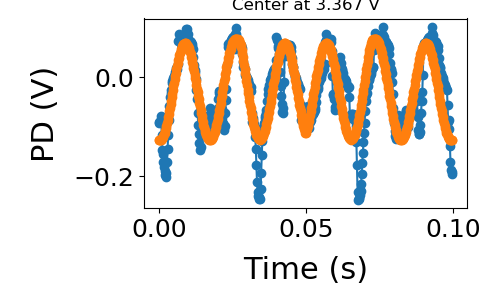

<IPython.core.display.Javascript object>


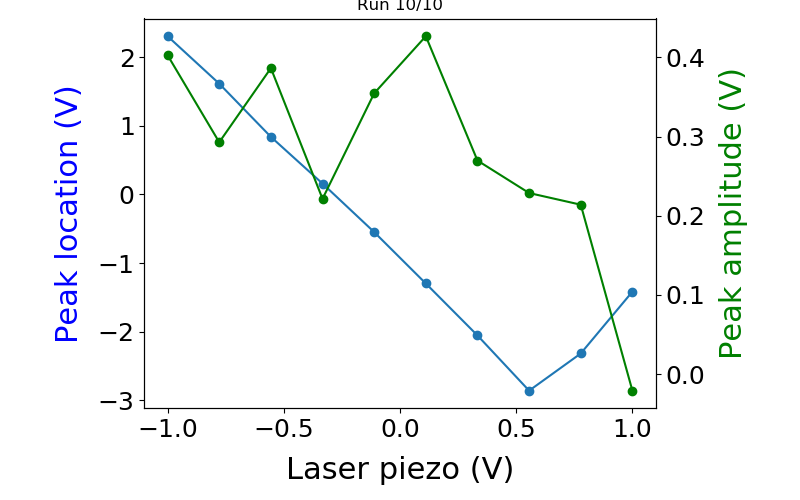

<IPython.core.display.Javascript object>


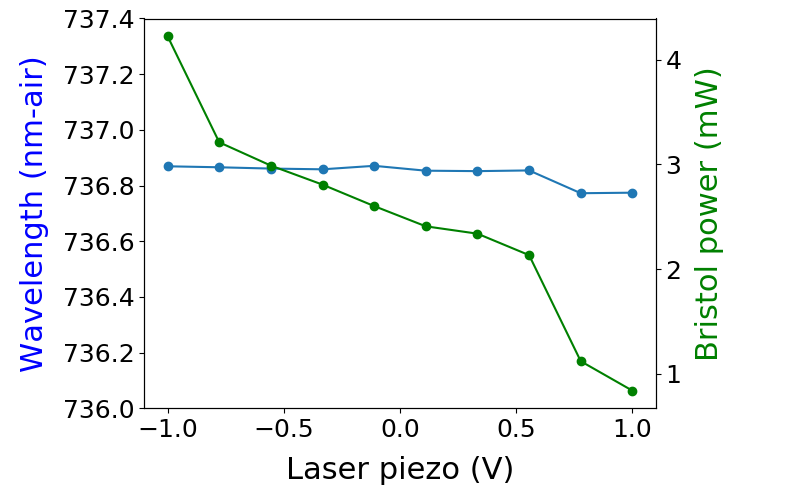

<IPython.core.display.Javascript object>


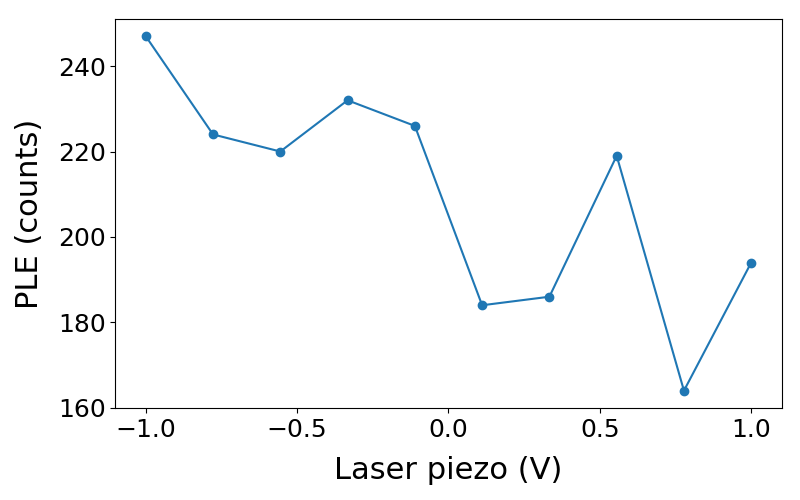

Initialization time (s) = 0.5760331153869629
Loop 0 time (s) = 1.7460999488830566, FP scan time (s) = 0.11600661277770996, FP fit time (s) = 0.00700068473815918, FP time (s) = 0.3670210838317871, Bristol time (s) = 0.19401121139526367
Loop 1 time (s) = 1.7561004161834717, FP scan time (s) = 0.11700677871704102, FP fit time (s) = 0.009000539779663086, FP time (s) = 0.3800218105316162, Bristol time (s) = 0.18001031875610352
Loop 2 time (s) = 1.7270987033843994, FP scan time (s) = 0.11800694465637207, FP fit time (s) = 0.008000373840332031, FP time (s) = 0.36402082443237305, Bristol time (s) = 0.17901015281677246
Loop 3 time (s) = 1.762101173400879, FP scan time (s) = 0.11600661277770996, FP fit time (s) = 0.009000539779663086, FP time (s) = 0.3740215301513672, Bristol time (s) = 0.18101024627685547
Loop 4 time (s) = 1.7420992851257324, FP scan time (s) = 0.11600661277770996, FP fit time (s) = 0.007000446319580078, FP time (s) = 0.356020450592041, Bristol time (s) = 0.17100977897644043
Lo

In [63]:
# scan laser frequency in discrete steps
# software timed
time_start = time.time()

toptica_bounded_write(-1)
voltage = np.linspace(-1,1,10)
FP_FSR_V =4.783

lpFP = LivePlot(1, 2, 5, 3, 'o', 'Time (s)',"PD (V)")
lpLRFP = LivePlotLR(1, 1, 8, 5, 'o', 'Laser piezo (V)', 'Peak location (V)','Peak amplitude (V)')
lpLR = LivePlotLR(1, 1, 8, 5, 'o', 'Laser piezo (V)', 'Wavelength (nm-air)','Bristol power (mW)')
lpPLE = LivePlot(1, 2, 8, 5, 'o', 'Laser piezo (V)',"PLE (counts)")

volt_so_far=[]
powerlist=[]
lambdalist=[]

FPlambda=[]
FPpower=[]

PLElist=[]

# initialize DG645
DG645_init()
DG_trig_write(False) # initialize trigger to a low state

intialization_time = time.time()-time_start
print(f'Initialization time (s) = {intialization_time}')

time.sleep(0.1) # wait for a short time 
shutter_ctrl_write(False)
time.sleep(0.1) # wait for a short time
# switch filter to 750 LP
efw_instance.change_filter('750LP')
while True:
    if efw_instance.read_position() == efw_instance.EFW_wheel_filter['750LP']:
        break
    else:
        efw_instance.change_filter('750LP')
time.sleep(0.1) # wait for a short time 
shutter_ctrl_write(True)
time.sleep(0.1) # wait for a short time 
       

        
center_NV = True
center_per_N_run = 10 # center NV every N runs

# liveplot readings so far
for ind,v in enumerate(voltage):
    try:
        tstart_loop=time.time()
        toptica_bounded_write(v) # task_toptica.write(v, auto_start=True, timeout=5)
        volt_so_far.append(v)
        # initialize counter
        PLE_APD = CI(APD_terminal,APD_ctr)
        PLE_APD.start()

        # output high on a digital channel, which is connected to the DG645 trigger input
        # this set up the pulse sequence
        DG_trig_write_pulse()

        # wait till the burst is done
        time.sleep(time_per_point)

        # read counts
        APD_count = PLE_APD.read_counts()

        PLE_APD.close()
        PLElist.append(APD_count)
        lpPLE.plot_live(volt_so_far,PLElist)

        # keep 737 laser (AOM) on
        DG645_737_polarity(0)
        time.sleep(0.01) # wait for a short time

        # read fabry perot - need to start the read and write channel at the same time
        tstart_FP=time.time()
        t0_this,v_ao_scan_this,aiV_this = FP_scan()
        tscan_FP = time.time()-tstart_FP

        ts1 = time.time()
        best_vals = FP_fit(t0_this,v_ao_scan_this, aiV_this)
        tfit_FP = time.time() - ts1

        if ind==0:
            FPlambda.append(best_vals[1])
        else:
            FPlambda.append(unwrap_by_pt(best_vals[1],FPlambda[ind-1],FP_FSR_V))
        FPpower.append(-best_vals[0])

        yfit = lorentziansin(v_ao_scan_this, best_vals[0], best_vals[1],best_vals[2],best_vals[3],best_vals[4],best_vals[5],best_vals[6])
        lpFP.plot_live(t0_this,aiV_this,yfit)
        lpFP.ax1.set_title(f'Center at {best_vals[1]:.3f} V')
        lpFP.fig.canvas.draw()
        plt.tight_layout()

        lpLRFP.plot_live(volt_so_far, FPlambda,FPpower)
        lpLRFP.ax1.set_title(f'Run {ind+1}/{len(voltage)}')
        lpLRFP.fig.canvas.draw()
        plt.tight_layout()

        ttot_FP = time.time()-tstart_FP

        # read wavemeter
        tstart_bristol=time.time()
        currentLambda,currentPower = readBristol(bristol521handle)
        lambdalist.append(currentLambda)
        powerlist.append(currentPower)

        lpLR.plot_live(volt_so_far, lambdalist,powerlist)
        lpLR.ax1.set_ylim([736,737.4]) # harwire limit
        ttot_bristol = time.time()-tstart_bristol
        # back to 737 nm laser default off
        DG645_737_polarity(1)

        # re-center NV every few cycles
        if center_NV and (ind % center_per_N_run == center_per_N_run-1):
            DG645_set_polarity(BNC_532,1)
            DG645_set_polarity(BNC_637,1)
            DG645_set_polarity(BNC_737,1)
            time.sleep(0.1) # wait for a short time 
            shutter_ctrl_write(False)
            time.sleep(0.1) # wait for a short time
            efw_instance.change_filter('open')
            while True:
                if efw_instance.read_position() == efw_instance.EFW_wheel_filter['open']:
                    break
                else:
                    efw_instance.change_filter('open')
            DG645_set_polarity(BNC_532,0)
            DG645_set_polarity(BNC_637,0)

            # track NV
            time.sleep(2)

            # reverse
            # configure system back to PLE measurement
            DG645_set_polarity(BNC_532,1)
            DG645_set_polarity(BNC_637,1)
            efw_instance.change_filter('750LP')
            while True:
                if efw_instance.read_position() == efw_instance.EFW_wheel_filter['750LP']:
                    break
                else:
                    efw_instance.change_filter('750LP')
            time.sleep(0.1) # wait for a short time 
            shutter_ctrl_write(True)
            time.sleep(0.1) # wait for a short time 

        # incremental save data to file

        t_loop = time.time()-tstart_loop
        print(f'Loop {ind} time (s) = {t_loop}, FP scan time (s) = {tscan_FP}, FP fit time (s) = {tfit_FP}, FP time (s) = {ttot_FP}, Bristol time (s) = {ttot_bristol}')
    except:
        PLE_APD.close()
        # close shutter
        time.sleep(0.1)
        shutter_ctrl_write(False)
        time.sleep(0.2)
        
        # wait till the current burst cycle is done
        time.sleep(time_per_point)
        
        # default OFF state
        DG645_set_polarity(BNC_532,1)
        DG645_set_polarity(BNC_637,1)
        DG645_set_polarity(BNC_737,1)
        
        # switch filter to 750 LP
        efw_instance.change_filter('750LP')
        while True:
            if efw_instance.read_position() == efw_instance.EFW_wheel_filter['750LP']:
                break
            else:
                efw_instance.change_filter('750LP')

toptica_bounded_write(0)
DG645_default()

time.sleep(0.1) # wait for a short time 
shutter_ctrl_write(False)
time.sleep(0.1) # wait for a short time 

save_data = False
if save_data:
    data_type = 'PLEScan'
    data_header=f"""time_per_point = {time_per_point} # sec 
    init_time = {init_time} # 637 nm, sec
    PLE_time = {PLE_time} # 737 nm, sec
    delay637 = {delay637}
    delay737 = {delay737}
    delay532 = {delay532}
    marginFront = {marginFront} # allow the excitation laser to truely turn off, let the defect decays to its ground state
    marginBack = {marginBack} # some margin at the back to avoid the initialization laser turning on in the PLE time
    piezo control (V) PLE (counts) wavelength(nm-air) power(mW) FP lambda (V) FP power (V)
    """    
    data_array = np.array([volt_so_far,PLElist, lambdalist,powerlist,FPlambda,FPpower]).T
    data_save(data_array, None, data_type, data_header)

time_total = time.time()-time_start
print(f'Total run time (s) = {time_total}')

In [ ]:
# ~ 0.64 sec for FP scan, read wavemeter, and updating graphs

In [55]:
tstart = time.time()
readBristol(bristol521handle)
print(time.time()-tstart)

0.20101165771484375


In [60]:
# 50 ms to query Bristol wavelength meter
# 100 ms in total for both wavelength and power
tstart = time.time()
CLGetLambdaReading(bristol521handle)
# CLGetPowerReading(bristol521handle)
print(time.time()-tstart)

0.05100297927856445


In [57]:
# Hardware timed 
# construct a list of voltages to write
# generate an on board clock with the rate desired

In [79]:
# 20 - 40 ms to update DG645 polarity (with open channel, write, and close channel)
tstart = time.time()
DG645_737_polarity(1)
print(time.time()-tstart)

0.022001266479492188


In [87]:
# 1 ms to write to DG645
dg_source = DG645(DG645_address)
tstart = time.time()
dg_source.set_polarity(BNC_737,1)  
print(time.time()-tstart)
dg_source.close()

0.0010001659393310547


In [89]:
# 4 ms to write to toptica
tstart = time.time()
toptica_bounded_write(v)
print(time.time()-tstart)

0.004000186920166016


In [12]:
# set instruments back to default state and close communication channels
# task_toptica.write(0)
# task_toptica.close()
# dg_source.close()